In [1]:
import numpy as np
from shapely.geometry import Polygon, LineString

def generate_racks(rows, cols, rack_width=1000, rack_height=4000, walkway_width=2000):
    """
    Generates rack polygons in a traditional warehouse layout.
    :param rows: Number of rows of racks
    :param cols: Number of columns of racks
    :param rack_width: Width of each rack in mm
    :param rack_height: Height of each rack in mm
    :param walkway_width: Width of walkways between racks in mm
    :return: (list of polygons representing racks, list of all vertices)
    """
    rack_polygons = []
    vertices = []

    for row in range(rows):
        for col in range(cols):
            # Bottom-left corner of the rack
            x_start = col * (rack_width + walkway_width)
            y_start = row * (rack_height + walkway_width)

            # Create a polygon for the rack
            rack_polygon = Polygon([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])
            rack_polygons.append(rack_polygon)

            # Add the rack's vertices to the vertex list
            vertices.extend([
                (x_start, y_start),
                (x_start, y_start + rack_height),
                (x_start + rack_width, y_start + rack_height),
                (x_start + rack_width, y_start)
            ])

    return rack_polygons, vertices


def generate_dummy_obstacles(vertices, path_width=1200):
    """
    Generates dummy obstacles to block paths narrower than a specified width.
    :param vertices: List of vertices (points) representing waypoints
    :param path_width: Minimum allowed width for valid paths in mm
    :return: List of dummy obstacle polygons
    """
    dummy_obstacles = []
    for i in range(0, len(vertices), 2):  # Assume sequential pairs of vertices
        x1, y1 = vertices[i]
        x2, y2 = vertices[i + 1] if i + 1 < len(vertices) else (x1, y1)

        # If the distance between vertices is less than the minimum path width
        if abs(x2 - x1) < path_width and abs(y2 - y1) < path_width:
            dummy_obstacle = Polygon([
                (x1 - path_width / 2, y1 - path_width / 2),
                (x1 + path_width / 2, y1 - path_width / 2),
                (x1 + path_width / 2, y1 + path_width / 2),
                (x1 - path_width / 2, y1 + path_width / 2)
            ])
            dummy_obstacles.append(dummy_obstacle)

    return dummy_obstacles


def generate_adjacency_matrix(vertices, polygons):
    """
    Generates the adjacency matrix for vertices with polygons as obstacles.
    :param vertices: List of (x, y) coordinates representing vertices
    :param polygons: List of polygon obstacles
    :return: N-by-N binary adjacency matrix
    """
    N = len(vertices)
    adjMat = np.ones((N, N), dtype=int)  # Start with all connections allowed

    for i in range(N):
        for j in range(i + 1, N):  # Check pairs of vertices
            if i != j:
                line = LineString([vertices[i], vertices[j]])  # Line segment

                # Check if the line intersects any polygon
                for poly in polygons:
                    if line.intersects(poly):
                        adjMat[i, j] = 0  # Block the connection
                        adjMat[j, i] = 0  # Symmetry
                        break

    return adjMat


In [2]:
# Define layout parameters
rows = 4
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000
min_path_width = 1200

# Generate racks and vertices
rack_polygons, vertices = generate_racks(rows, cols, rack_width, rack_height, walkway_width)

# Generate dummy obstacles for narrow paths
dummy_obstacles = generate_dummy_obstacles(vertices, path_width=min_path_width)

# Combine racks and dummy obstacles into the polygon list
polygons = rack_polygons + dummy_obstacles

# Generate adjacency matrix
adjMat = generate_adjacency_matrix(vertices, polygons)

# Print adjacency matrix
print("Adjacency Matrix:")
print(adjMat)


Adjacency Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


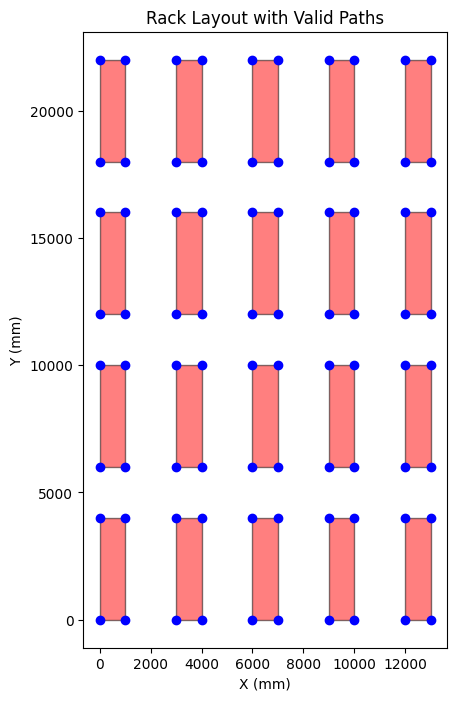

In [3]:
import matplotlib.pyplot as plt

def visualize_layout(vertices, polygons, adjMat):
    """
    Visualizes the rack layout, dummy obstacles, and valid edges.
    :param vertices: List of vertices
    :param polygons: List of polygons (racks and obstacles)
    :param adjMat: Adjacency matrix
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot polygons (racks and obstacles)
    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='red', ec='black')  # Obstacle

    # Plot vertices
    for x, y in vertices:
        ax.plot(x, y, 'bo')  # Vertex point

    # Plot edges based on adjacency matrix
    N = len(vertices)
    for i in range(N):
        for j in range(i + 1, N):
            if adjMat[i, j] == 1:
                x_coords = [vertices[i][0], vertices[j][0]]
                y_coords = [vertices[i][1], vertices[j][1]]
                ax.plot(x_coords, y_coords, 'g-')  # Valid edge

    plt.title("Rack Layout with Valid Paths")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Visualize the layout
visualize_layout(vertices, polygons, adjMat)
